# Nano GPT

Nano GPT implementation by Andrej Karpathy.

## Nano GPT YouTube Lecture version

This is for lecture only. The Github is different from the proper implementation of Nano GPT github. Do not confuse/mix two diffent Github repositories.

* [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)
* [Github - nanogpt-lecture](https://github.com/karpathy/ng-video-lecture)

> Code created in the Neural Networks: Zero To Hero video lecture series, specifically on the first lecture on nanoGPT. Publishing here as a Github repo so people can easily hack it, walk through the git log history of it, etc.


## Nano GPT implementation version
* [Github nanoGPT](https://github.com/karpathy/nanoGPT)


In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
import os
import sys

DIR = os.path.dirname(os.path.abspath('..'))
if DIR not in sys.path:
    sys.path.append(DIR)

In [6]:
%load_ext autoreload
%autoreload 2


import inspect
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from bigram import (
    get_batch,
)

from transformer.v1 import (
    TYPE_FLOAT,
    calculate_dot_product_similarities,
    calculate_attentions,
    scale,
    mask,
    MultiHeadAttention,
    ScaledDotProductAttention,
    PositionwiseFeedForward,
    PositionalEncoding,
    Encoder,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Data

Using tinyshakespeare as the dataset

In [6]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-01-20 17:07:45--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2024-01-20 17:07:46 (7.23 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



# Terminologies

* B: Batch size
* T: Time steps or Sequence length (e.g. 512 for bert input sequence)
* C: Channel or Feature (channel perhaps because Andrej is from CNN background?). ```C=2``` two features in each x.

## Batch Input

<img src="./image/gpt_batch.jpeg" align="left" width=750/>


## Bigram Language Model

The Bigram Language Model is **NOT using context of size T** but using the current token to predict next token, hence **Bi**gram. The objective of a Language Model is to use the historycal context, but here in the Bigram Model, Andrej is building very simple Markov Chain process to **generate next token only from the current token** for the sake of explaning the basic idea of token generation with bare naked possible way as he mentioned at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2077) and [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2261).

> right now the history is not used, so it looks silly (but eventually history will be used). ...
> 
> Given the previous context of whatever generated, we only look at the very last character (```[:, -1, :]```) to make the prediciton of what comes next.

* [Let's build GPT: from scratch, in code, spelled out - simplest baseline](https://youtu.be/kCc8FmEb1nY?t=1383)

The ```idx:shape(B,T)``` is the idices to extract ```T``` number embedding vectors for the tokens. The ```token_embedding_table``` is e.g. a table of word embeddings in Word2Vec for each word in the vocabulary of the language. Andrej is using ```vocab_size``` as the dimension of the token embedding vector dimensions, hence the table has ```(number of words in language, dimensions)==(vocab_size, vocab_size)```. 

The reason using ```vocab_size``` as the dimensions is because Andrej simlifies the classification head which predicts the next token. Usually there is a **fully connected (FC)** layer that reduces the higher dimension down to N classes to predict, then apply softmax and argmax to select the hightest probability token index. Here, he skipped **FC** and directly generate N class outputs where ```N==vocab size``` so that the model can directly predict which word in the vocabulary to come next as GPT output.

<img src="./image/andrej_gpt_dev_idx.png" align="left" width=500/>

The ```generate``` function is the mechanism to continuously generate the next tokens from the given context (prompt). In this Bigram Language Model, the (last) token predicts the next token, hence take the last token embedding vector with ```[:, -1, :]``` to get the next token id via softmax and argmax (```torch.multinomial(, num_samples=1)```) as the next token.

<img src="./image/text_generation_from_prompt.png" align="left" width=500/>

This corresponds with GPT generates succeeding sentences given a prompt (context). 

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=1934)

By giving an index to one token as the first ```idx``` to the ```generate``` function, it will continuously generates ```max_new_tokens```.

```
# 0 as the index to the first token in the embedding table
first_token_index: int = torch.zeros((1, 1)  

# [0] to get first batch
first_batch = decode(m.generate(idx=first_token_index, dtype=torch.long), max_new_tokens=100)[0].tolist())  
print(first_batch)
```

<img src="./image/next_token_generation.jpeg" align="left" width=750/>

In [7]:
print(inspect.getsource(get_batch))

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y



---
# Transformer

(The Transformer implementaion starting at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2268))

Transformer generates a graph network between position-encoded tokens.

1. Get un-connected tokens as a sequence (e.g. sentence)
2. Wires connections among tokens by having looked at the co-occurrances of them in billions of sequences.

<img src="./image/transformer_architecture.png" align="left" width=350/>

## Attention 

$$Attention(Q,K,V)=softmax(\frac {QK^T}{\sqrt {d_k}})$$


* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4301)
* [Building a GPT](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-)

> - Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
> - There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
> - Each example across batch dimension is of course processed completely independently and never "talk" to each other
> - In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
> - "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
> - "Scaled" attention additional divides `similarity` by ```1/sqrt(head_size)```. This makes it so when input Q,K are unit variance, `similarity` will be unit variance too and Softmax will stay diffuse and not saturate too much.
> 
> <img src="./image/transformer_attention_as_communication.png" align="left" width=250/>

## Dot Product

Transformer uses Scaled Dot Product Attention. Refresh the memory on what dot-product transformation does and where they are used.

* Similarity = Q@K
* Attention Valuye = Similarity@V

<img src="./image/transformer_self_attention_flow.jpeg" align="left"/>

# Scaled Dot Product Attention

<img src="./image/transformer_scaled_dot_product_attention.png" align="left" width=150/>

In [13]:
print(inspect.getsource(ScaledDotProductAttention.forward))

    def forward(
            self,
            q: Tensor,
            k: Tensor,
            v: Tensor,
    ):
        """Calculate the scaled dot product attention.
        Args:
            q: query of shape (B,h,T,d)
            k: key of shape (B,h,T,d)
            v: value of shape (B,h,T,d)
        """
        # --------------------------------------------------------------------------------
        # First MatMul in the Scaled Dot Product Attention to calculate the similarities
        # matrix between (q,k) for every (q,k) combinations in Q, K.
        # This is cartesian product matrix of shape (T, T) for every head and batch.
        # The number of features in similarities matrix is B*H*T*T which will be
        # (32 * 8 * 512 * 512) which is 64M. Each feature has 512 / H = 64 dimensions
        # of float32, hence the size is 16G bytes of memory requirement.
        # --------------------------------------------------------------------------------
        similarities: Ten

## First MatMul with Q and K (Calculate Similarity Score)

For every token ```Q``` in a sequence, calculate the relation/communication with other token ```K``` in the sequence (for GPT, only previous tokens). This builds the graph network of Self Attention.


|Similarity Score (Q & K)| Proabability as Softmax |
|---|---|
|<img src="./image/transformer_dot_product_attention_similarity_score.jpeg" align="left" width=500/>|<img src="./image/transformer_dot_product_attention.png" align="left" width=175/>|


In [13]:
print(inspect.getsource(calculate_dot_product_similarities))

def calculate_dot_product_similarities(
        query: Tensor,
        key: Tensor,
) -> Tensor:
    """
    Calculate similarity scores between queries and keys using dot product.

    Args:
        query: embedding vector of query of shape (B, h, T, d_k)
        key: embedding vector of key of shape (B, h, T, d_k)

    Returns: Similarities (closeness) between q and k of shape (B, h, T, T) where
        last (T, T) represents relations between all query elements in T sequence
        against all key elements in T sequence. If T is people in an organization,
        (T,T) represents all (cartesian product) social connections among them.
        The relation considers d_k number of features.
    """
    # --------------------------------------------------------------------------------
    # Relationship between k and q as the first MatMul using dot product similarity:
    # (B, h, T, d_k) @ (B, hH, d_k, T) ---> (B, h, T, T)
    # --------------------------------------------------------


## Scale by $\sqrt{d_k}$

As in the name **Scaled** Dot-Product Attention, the similarity score is normalized by $\sqrt{d_k}$ to manage the variance where $d_k$ is the dimension of the key vector $k$ (which is the same with that of query).

Suppose the positionally encoded token vector $x$ has dimension $D$, the shape of $W_K$ is ```(M, D)```. Then key $k = x:(D,) @ W^T_K:(D,M)$ has the shape $(M,)$, which is $d_k$. The variance of the pdorduct $Q\cdot K^T$ is $d_k$. The variance of two zero-mean normal distributions is:

[Variance of product of multiple independent random variables](https://stats.stackexchange.com/questions/52646/)

$${\rm Var}(XY) = E(X^2Y^2) − (E(XY))^2={\rm Var}(X){\rm Var}(Y)+{\rm Var}(X)(E(Y))^2+{\rm Var}(Y)(E(X))^2$$  $$E(X)=E(Y)=0$$

<img src="./image/variance_of_q@k.jpeg" align="left" width=500/>

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4616)

> If you have unit gausian input of mean 0 and $W_K$ and $W_V$ are unit gaussian, and if you calculate the ```similarity``` naively, the variance is the order of the head size $d_k$ (e.g. approx 16 if $d_k$ == 16). By standardizing the ```similarity``` score by $\sqrt{d_k}$ the variance of the ```similarity``` socre will be normal (approx 1.0).

Otherwise, softmax will pickup the nodes with larger values, hence only specific nodes in the sequence will be incorporated into the BoW. We want to consider the communication among every nodes if there is, not specific ones only.

### Without scaling

When the similarity score is not normalized/scaled by $\sqrt{d_k}$, the softmax becomes **peaky** like one hot encoding, which is beneficial for classification (amplify the high score signal).

variance:14.592000007629395, softmax:tensor([7.8424e-03, 3.1967e-04, 3.8844e-02, 6.4541e-05, 9.5293e-01])


<StemContainer object of 3 artists>

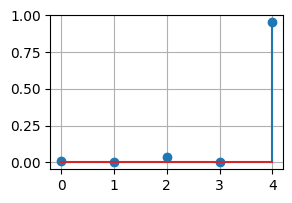

In [10]:
head_size = 16
naive_score = torch.tensor([0.1, -0.1, 0.2, -0.2, 0.4]) * head_size
# Note that variance is close to the head_size
print(f"variance:{naive_score.var()}, softmax:{torch.softmax(naive_score, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(naive_score)), torch.softmax(naive_score, dim=-1))

### With scaling

By scale/normalize, the softmax will be smoothed/diffused.

variance:0.9120000004768372, softmax:tensor([0.1524, 0.0685, 0.2273, 0.0459, 0.5059])


<StemContainer object of 3 artists>

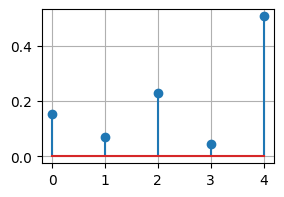

In [11]:
scaled_score = naive_score / torch.sqrt(torch.tensor(head_size))
print(f"variance:{scaled_score.var()}, softmax:{torch.softmax(scaled_score, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(scaled_score)), torch.softmax(scaled_score, dim=-1))

### Code for Scale

In [18]:
print(inspect.getsource(scale))

def scale(
        similarities: Tensor,
        d_k: int
) -> Tensor:
    """
    Standardize the variance of the dot product similarities using the standard deviation
    of the dot product of the normal distributions std=sqrt(d_k) so that the variance will
    be 1.0 approx.

    Citation:
    > While for small values of dk the two mechanisms perform similarly, additive attention
    > outperforms dot product attention without scaling for larger values of dk [3].
    > We suspect that for large values of d_k, the dot products grow large in magnitude,
    > pushing the softmax function into regions where it has extremely small gradients.
    > To counteract this effect, we scale the dot products by sqrt(d_k).

    The last (T, T) of the shape (B,h,T,T) is the matrix that represents the similarities
    as the dot product between (q,k) from every q from sequence length T and k from the
    sequence length T. The dimensions of q and k are both d_k, and q, k are expected to
    follow n

## Mask

Optional. After calculating ```(T,T)``` matrix of similarities from q to k, mask the matrix to prevent the communications with future time steps by replacing the similarity values with the ```-inf```, meaning there is **no relationship** from ```q```. Then softmax will make the contribution from the ```-inf``` to zero. This is the same with blocking relations between ```q``` and ```k```.

In [14]:
_T = 4
_B = 1
_H = 2

# Mask matrix to decide which element in (T,T) matrix to mask
mask = torch.tril(torch.ones(_T,_T)) == 0
mask

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [15]:
# Mask the similarity matrix element of future steps with -inf
similarities = torch.randn(_B,_H,_T,_T)
similarities = similarities.masked_fill(mask=mask, value=float('-inf'))
similarities

tensor([[[[ 1.9312,    -inf,    -inf,    -inf],
          [-0.1360,  1.6354,    -inf,    -inf],
          [ 1.1415,  0.0186, -1.8058,    -inf],
          [-0.3753,  1.0331, -0.6867,  0.6368]],

         [[-0.9727,    -inf,    -inf,    -inf],
          [ 0.2695, -0.2104,    -inf,    -inf],
          [ 0.3488,  0.9676, -0.4657,    -inf],
          [-2.4801, -0.4175, -1.1955,  0.8123]]]])

In [16]:
# Softmax will supress the contirubion from -inf similarity values
F.softmax(similarities, dim=-1)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.1454, 0.8546, 0.0000, 0.0000],
          [0.7258, 0.2361, 0.0381, 0.0000],
          [0.1166, 0.4770, 0.0854, 0.3209]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.6177, 0.3823, 0.0000, 0.0000],
          [0.3031, 0.5627, 0.1342, 0.0000],
          [0.0254, 0.1997, 0.0917, 0.6832]]]])

### Code for Mask

In [20]:
print(inspect.getsource(mask))

def mask(
    similarities: Tensor,
    mask_matrix: Tensor
) -> Tensor:
    """
    Args:
        similarities: matrix to mask of shape (B,H,T,T)
        mask_matrix: boolean matrix of which elements in (T,T) to mask fill.

    Returns: masked similarity matrix
    """
    # --------------------------------------------------------------------------------
    # mask to make uni-direction (left to right only) for algorithm such as GPT.
    # Skip masking for bi-directional e.g .BERT,
    # --------------------------------------------------------------------------------
    # exp(-inf) = 0 masks the similarities so that it will be uni-directional.
    assert (
        similarities.ndim == 4 and                              # (B,H,T,T)
        similarities.shape[-2] == similarities.shape[-1] and
        similarities.shape[-1] == mask_matrix.shape[-1]
    )
    masked = similarities.masked_fill(mask=mask_matrix, value=float('-inf'))
    return masked



## Second MatMul with V (Calculate Bag of Words Attention Value)

One way to generate the inter-connections among the tokens to distill their knowledges or relations is ```BoW``` by averaging them feature-wise/axis=-1.



<img src="./image/transformer_dot_product_attention_bow.png" align="left" width=700/>  

Note that the initially the value of similarity is random or ```(1.0, 1/2, 1/3, ...)``` but eventually it gets trained to memorize the relations among position-encoded tokens.

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=3814)

> Different will find other tokens more or less interesting and we want that data dependent. If I/token is a vowel, I am looking for consonants in my past and want to know what consonants were. And I want the information to flow to me (connection). This is the problem that Self Attention solves.

<img src="./image/self_attention.jpeg" align="left" width=700/>

### Purpose of  using $W_V$

$v$ looks to be a proxy of $x$ but what transformation or meaning does $W_V$ gives by having transformation from $x$ to $v$? (Note: ```x``` in the diagram above is actually $v$ as $v=x@W{_V}{^T}$).

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4258)

> $x$ is like a private information to a token. For the purpose of the single attention head, $v$ is what I give for you to communicate with if you find me interesting.

### Code

In [14]:
print(inspect.getsource(calculate_attentions))

def calculate_attentions(
        similarities,
        value
):
    """
    For every q element, create a Bag of Words that encodes the relationships with
    other elements (including itself) in T, using (q,k) relationship value as the
    strength of the relationships.

    Citation:
    > On each of these projected versions of queries, keys and values we then perform
    > the attention function in parallel, yielding d_v-dimensional output values.

    ```
    bows = []
    for row in relationships:                 # relationship matrix of shape (T,T)
        bow = sum([                           # bow:shape(d_v,)
            k*v for (k,v) in zip(row,value)   # k:shape(), v:shape(d_v,)
        ])
        bows.append(bow)                      # bows:shape(T,d_v)
    ```

    Args:
        similarities: q to k relationship strength matrix of shape (B, h, T, T)
        value: elements of sequence with length T of shape (B, h, T, d_v)

    Returns: Bag of Words for every q element of s

# Multi Attention Head

Divide the embedding vector q, k, v into ```h``` number of segmenets and apply self attention to each segment in parallel respectively.

* <img src="./image/transformer_paper_multi_head_attention.png" align="left" width=700/>


|<img src="./image/transformer_multi_head_attentions.png" align="left" width=200/>   | 
<img src="./image/transformer_multi_head_attention_formula.png" align="left" width=700/> |

* [Transformers Explained Visually (Part 3): Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

<img src="./image/transformer_multi_head_attention.png" align="left" width=500/>

In [10]:
print(inspect.getsource(MultiHeadAttention))

class MultiHeadAttention(nn.Module):
    """
    Class to implement Multi Head Attention (Figure 2 right in the paper).
    Citation:
    > The encoder is composed of a stack of N = 6 identical layers. Each layer has two
    > sub-layers. The first is a multi-head self-attention mechanism, and the second is
    > a simple, position-wise fully connected feed-forward network. ... To facilitate
    > these residual connections, all sub-layers in the model, as well as the embedding
    > layers, produce outputs of dimension d_model = 512.

    > Instead of performing a single attention function with d_model dimensional
    > keys, values and queries, we found it beneficial to linearly project
    > the queries, keys and values h times with different, learned linear projections
    > to d_k, d_k and d_v dimensions, respectively.
    > On each of these projected versions of queries, keys and values we then perform
    > the attention function in parallel, yielding d_v dimensional output valu

In [17]:
B = 2
T = 8
C = 4

mha = MultiHeadAttention(
    num_heads=2,
    dim_input=C,
    dim_output=C,
    bias=True,
    dropout_ratio=0.0
)


x = torch.randn(B,T,C)

# Positionwise Feed Forward

This is a single hidden layer neural network with ReLU activation. Here the features in the attention vector of each token can be amplified or supressed by weights, and multiple combination of features can form a new feature as the output.

<img src="./image/transformer_paper_pointwise_feedforward.png" align="left" width=700/>

In [11]:
print(inspect.getsource(PositionwiseFeedForward))

class PositionwiseFeedForward(nn.Module):
    """Class to implementation of Position-wise Feed-Forward Networks.
    This is a single hidden layer nural network with ReLU activation.

    Citation:
    > The encoder is composed of a stack of N = 6 identical layers. Each layer has two
    > sub-layers. The first is a multi-head self-attention mechanism, and the second is
    > a simple, position-wise fully connected feed-forward network. ... To facilitate
    > these residual connections, all sub-layers in the model, as well as the embedding
    > layers, produce outputs of dimension d_model = 512.

    > We apply dropout to the output of each sub-layer, before it is added to the
    > sub-layer input and normalized. In addition, we apply dropout to the sums of the
    > embeddings and the positional encodings in both the encoder and decoder stacks.
    > For the base model, we use a rate p_drop = 0.1.

    > each of the layers in our encoder and decoder contains a fully connected feed-

# Encoder



In [12]:
print(inspect.getsource(Encoder))

class Encoder(nn.Module):
    """Class to implement Transformer Encoder.
    Citation:
    > In addition, we apply dropout to the sums of the embeddings and
    > the positional encodings in both the encoder and decoder stacks.
    > For the base model, we use a rate p_drop = 0.1.
    """
    @property
    def D(self) -> int:
        """Dimension of the model embedding vector
        """
        return self._D

    def __init__(
            self,
            vocabulary_size: int,
            max_positional_length: int = 5000,
            num_layers: int = 6,
            num_heads: int = 8,
            d_model: int = 512,
            dtype: type = TYPE_FLOAT,
            d_ff: int = 2048,
            do_mask: bool = False,
            max_time_steps: int = 512,
            bias: bool = True,
            p_drop: float = 0.1,
            eps: float = 1e-5
    ):
        super().__init__()
        self._D: int = d_model

        self.embedding: nn.Embedding = nn.Embedding(
            num_

In [ ]:
torch.tensor

In [ ]:
np.exp(0.1)

In [ ]:
np.exp(0.4)